In [322]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import cvxpy as cp
import scipy

rng = np.random.default_rng()

In [881]:
t_i = rng.uniform(0, 1, 500)
t_i.sort()

In [882]:
def rbf(x, center, epsilon):
    return np.exp(-(epsilon * (x - center))**2)

In [883]:
rbfs = [partial(rbf, center=i, epsilon=50) for i in [0.2, 0.4, 0.6, 0.8]]


true_y = 6 * np.sum([(t_i - 0.5) ** k for k in [1, 2, 3]], axis=0) + 2.5 * np.sum(
    [(-1) ** j * rbfs[j - 1](t_i) for j in [1, 2, 3, 4]], axis=0
)
obs_y = true_y + rng.normal(0, 0.25**2, len(t_i))

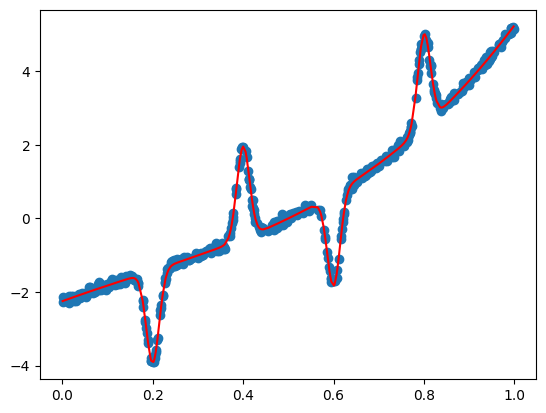

In [884]:
plt.scatter(t_i, obs_y)
plt.plot(t_i, true_y, color="r")

In [885]:
x_i = [0.167 * (n+1) for n in range(5)]
xs = np.linspace(0, 1, 100)

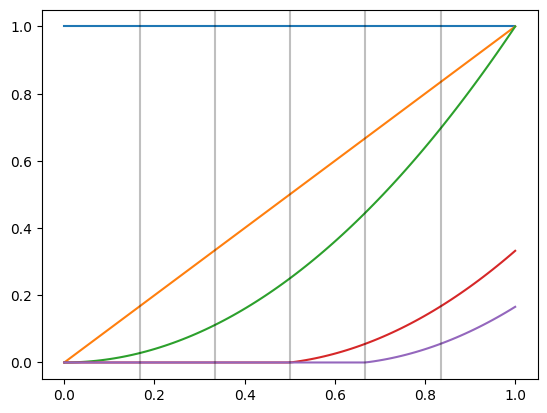

In [886]:
plt.plot(xs, np.ones_like(xs))
plt.plot(xs, [x for x in xs])
plt.plot(xs, [x**2 for x in xs])
plt.plot(xs, [(x - x_i[1]) * (x - x_i[2]) * int(x >= x_i[2]) for x in xs])
plt.plot(xs, [(x - x_i[2]) * (x - x_i[3]) * int(x >= x_i[3]) for x in xs])
for x in x_i:
    plt.axvline(x, alpha=0.25, color="black")

$$
j = 1, 2, \ldots, n \\
h_j(x) = x^{j-1} \quad \text{when} \quad j \leq k+1 \\
h_j(x) = \prod_{\ell=1}^k (x - x_{j-k-1+\ell}) * \mathbb{1}(x \ge x_{j-1}) \quad \text{when} \quad j \ge k+2
$$

$$
i = j - 1 = 0, 1, \ldots, n-1 \\
h_i(x) = x^i \quad \text{when} \quad i \le k \\
h_i(x) = \prod_{\ell=1}^k (x - x_{i-k+\ell}) * \mathbb{1}(x \ge x_{i}) = \prod_{\ell=0}^{k-1} (x - x_{i-k+\ell+1}) * \mathbb{1}(x \ge x_{i})\quad \text{when} \quad i \ge k+1
$$
But, given python is zero-indexed, we have to account for this because are notation is assuming one-indexing. So, we have:
$$
h_i(x) = \prod_{\ell=0}^{k-1} (x - x_{i-k+\ell}) * \mathbb{1}(x \ge x_{i-1})\quad \text{when} \quad i \ge k+1
$$

In [887]:
def tf_basis(x, k, x_i):
    results = []
    n = len(x_i)
    for i in range(n):
        if i <= k:
            h = x**i
            results.append(h)
        elif i >= k + 1:
            h = 1
            for ell in range(k):
                h *= x - x_i[i - k + ell]
            h *= int(x >= x_i[i - 1])
            results.append(h)
    return results

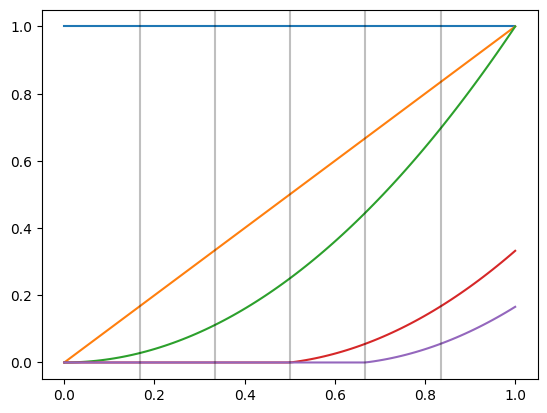

In [888]:
test = np.array([tf_basis(x, 2, x_i) for x in xs])

for n in range(test.shape[1]):
    plt.plot(xs, test[:, n])

for x in x_i:
    plt.axvline(x, alpha=0.25, color="black")

# Basis Function Approach

In [902]:
k = 0
basis_eval = np.array([tf_basis(t, k, t_i) for t in t_i])
beta = cp.Variable(len(t_i))

objective = cp.Minimize(0.5 * cp.sum_squares(obs_y - basis_eval @ beta) + 1 * cp.norm(beta[k+1:], 1))
prob = cp.Problem(objective)
results = prob.solve(solver="CLARABEL", verbose=True)

                                     CVXPY                                     
                                     v1.5.1                                    
(CVXPY) Jun 09 02:45:06 PM: Your problem has 500 variables, 0 constraints, and 0 parameters.
(CVXPY) Jun 09 02:45:06 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 09 02:45:06 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 09 02:45:06 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jun 09 02:45:06 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 09 02:45:06 PM: Compiling problem (target solver=CLARABEL).

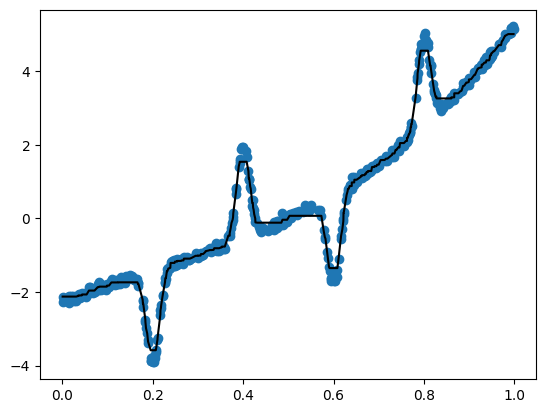

In [903]:
# High regularization results in the model only capturing the global trend. alpha = 0.01
# See coefficients to observe sparsity
predict = basis_eval @ beta.value.round(6)
plt.plot(t_i, predict, color="black")
plt.scatter(t_i, obs_y)

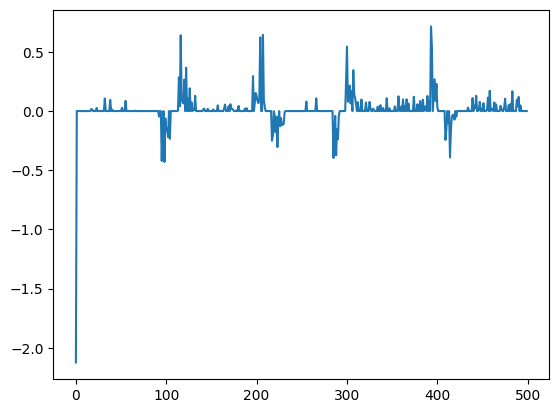

In [904]:
plt.plot(beta.value)

# Difference Operator Approach

In [931]:
k = 0
n = len(t_i)

ones = np.ones(n)
if k == 0:
    D = scipy.sparse.spdiags(np.vstack([-ones, ones]), range(2), m=n - k - 1, n=n)
elif k == 1:
    D = scipy.sparse.spdiags(
        np.vstack([ones, -2 * ones, ones]), range(3), m=n - k - 1, n=n
    )
elif k == 2:
    D = scipy.sparse.spdiags(
        np.vstack([-ones, 3 * ones, -3 * ones, ones]), range(4), m=n - k - 1, n=n
    )

In [932]:
beta = cp.Variable(n)
# plambda = cp.Parameter(1, nonneg=True)

objective = cp.Minimize(0.5 * cp.sum_squares(obs_y - beta) + 1000 * cp.norm(D @ beta, 1))
prob = cp.Problem(objective)

results = prob.solve(solver="CLARABEL", verbose=True)

                                     CVXPY                                     
                                     v1.5.1                                    
(CVXPY) Jun 09 03:14:02 PM: Your problem has 500 variables, 0 constraints, and 0 parameters.
(CVXPY) Jun 09 03:14:02 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 09 03:14:02 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 09 03:14:02 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jun 09 03:14:02 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 09 03:14:02 PM: Compiling problem (target solver=CLARABEL).

In [942]:
np.linalg.norm(D @ beta.value, ord=1)

3.185545538464396e-08

In [951]:
beta = cp.Variable(n)
lam = cp.Parameter(nonneg=True)

objective = cp.Minimize(0.5 * cp.sum_squares(obs_y - beta) + lam * cp.norm(D @ beta, 1))
prob = cp.Problem(objective)

results = []
for lam_value in np.logspace(-4, 6, 100):
    lam.value = lam_value
    prob.solve(solver="CLARABEL")
    results.append(np.sum((D @ beta.value).round(10)))

In [957]:
results

[7.407740505100001,
 7.407688134700001,
 7.4076220484,
 7.407538660600002,
 7.4074334426999995,
 7.407300704500001,
 7.407133557999999,
 7.4069721701999995,
 7.4069009996,
 7.406816759500001,
 7.4067105466,
 7.406576536099999,
 7.406407434099999,
 7.406194054299999,
 7.405924798299999,
 7.4055850357000015,
 7.405156303299999,
 7.404615305499998,
 7.403932644800001,
 7.4030712224,
 7.4019842323,
 7.4006126057,
 7.398881808800001,
 7.396697789599999,
 7.393941864,
 7.387271760599999,
 7.376740078299999,
 7.3634506022,
 7.3484831648,
 7.3442072323000005,
 7.336578187900001,
 7.3269514274,
 7.314803831099999,
 7.299475301299999,
 7.2837821057,
 7.2658025419,
 7.2473554700000005,
 7.2240779096,
 7.1947049631,
 7.1576405055,
 7.1156604481,
 7.0661955249999995,
 7.0143427655,
 6.953499525200001,
 6.882774015400001,
 6.800527412499999,
 6.7001538488,
 6.5993354952,
 6.5209347517,
 6.4472366555,
 6.376353828499999,
 6.3005034127999995,
 6.166489110700001,
 6.0105639907,
 5.8242740737,
 5.600490

In [959]:
results == 0

False

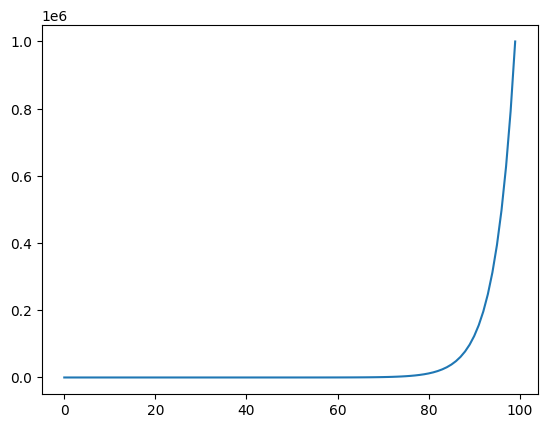

In [955]:
plt.plot(np.logspace(-4, 6, 100))

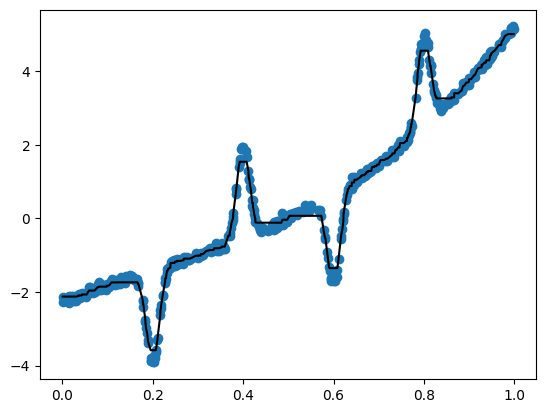

In [907]:
plt.plot(t_i, beta.value, color="black")
plt.scatter(t_i, obs_y)

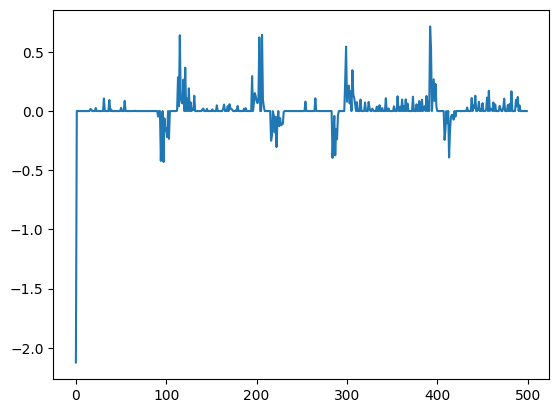

In [908]:
basis_beta = np.concatenate([beta.value[:k+1], D @ beta.value])

plt.plot(basis_beta)

In [909]:
xs = np.linspace(-0.5, 1.5, 10000)
oos_test = np.array([tf_basis(x, k, t_i) for x in xs])

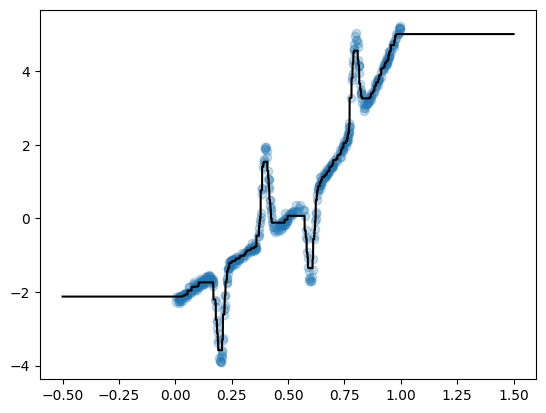

In [910]:
plt.scatter(t_i, obs_y, alpha=0.25)
plt.plot(xs, oos_test @ basis_beta, color="black")